In [ ]:
!curl ipinfo.io
!pip install yfinance 

## Parse Data

# 1. PACKAGE IMPORTING AND DATA COLLECTION


# Standard library imports
import os
import sys
import math
import warnings
import itertools
from math import sqrt
from datetime import datetime
from itertools import product
from datetime import datetime, timedelta

# Third-party library imports
from arch import arch_model
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pmdarima import auto_arima
from pandas.plotting import lag_plot
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
from keras.models import Sequential

# IPython display
from IPython.display import Image, display, HTML

# Matplotlib configuration
# rcParams['figure.figsize'] = 10, 6

In [ ]:
warnings.filterwarnings("ignore")
# Use a consistent style
plt.style.use('seaborn')

In [ ]:
# Download data
TICKER = "TSLA"
target_column = 'Close'
df = yf.download(TICKER, start="2018-01-01", end="2024-01-01").reset_index()

In [ ]:
csv_path = 'TSLA.csv'
df.to_csv(csv_path, index=False)

#### Split Data into training and testing sets

In [ ]:
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split the data into training and test sets
split_date = df.index[int(len(df) * 0.8)]
train = df[:split_date]
test = df[split_date:]

In [ ]:
df[['Open', 'High',	'Low',	'Close',	'Adj Close',	'Volume']].describe()

In [ ]:
df.dtypes

In [ ]:
# Check for missing values
df.isnull().sum()

In [ ]:
def plot_open_vs_high(df):
    plt.figure(figsize=(10, 6))

    # Scatter plot with 'Date' on x-axis and 'Close' on y-axis
    plt.scatter(df.index, df['Close'], color='blue', edgecolor='black')

    # Set title and labels
    plt.title('Close Price vs Date')
    plt.xlabel('Date')
    plt.ylabel('Close Price')

    # Format the x-axis to show dates clearly
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.grid(True)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_open_vs_high(test)
test.head()

In [ ]:
# Plot the closing price
plt.figure(figsize=(18, 7))
plt.plot(train.index, train['Close'])
plt.title(f'{TICKER} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Plot the closing price with shading for the testing period
plt.figure(figsize=(18, 7))

# Plot the training data
plt.plot(train.index, train['Close'], label='Training Data', color='blue')

# Plot the testing data
plt.plot(test.index, test['Close'], label='Testing Data', color='orange')

# Shade the testing area
plt.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.3)

# Set the title and labels
plt.title(f'{TICKER} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')

# Add grid and format the x-axis
plt.grid(True)
plt.xticks(rotation=45, ha='right', fontsize=9)

# Set major ticks to every 3 months and minor ticks to every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Add a legend
plt.legend()

# Adjust layout for better fit
plt.tight_layout()

# Display the plot
plt.show()


# Add Extra Features

# Feature Engineering (including previous features)
df['Daily_Return'] = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Price_Range'] = (df['High'] - df['Low']) / df['Open']
df['Volume_Change'] = df['Volume'].pct_change()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df['Volatility'] = df['Daily_Return'].rolling(window=20).std() * np.sqrt(252)
df['RSI'] = 100 - (100 / (1 + df['Daily_Return'].rolling(14).mean() / abs(df['Daily_Return']).rolling(14).mean()))

# Add Daily Percentage Change
df['Daily_Pct_Change'] = df['Close'].pct_change() * 100

# Remove rows with NaN values
df_clean = df.dropna()

# Select features for correlation analysis
features = ['Daily_Return', 'Log_Return', 'Price_Range', 'Volume_Change', 'MA_10', 'MA_30', 'Volatility', 'RSI', 'Daily_Pct_Change']

# Calculate correlation matrix
correlation_matrix = df_clean[features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Engineered Features (including Daily Percentage Change)')
plt.tight_layout()
plt.show()

correlation_matrix

# Display the first few rows of the new dataset
df_clean[features].head()

In [ ]:
# Calculate missing columns and add them to the DataFrame
# Moving Averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
std = df['Close'].rolling(window=20).std()
df['BB_middle'] = df['MA20']
df['BB_upper'] = df['BB_middle'] + (std * 2)
df['BB_lower'] = df['BB_middle'] - (std * 2)

# Volume Moving Average
df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()

# Price Momentum
df['Price_Momentum'] = df['Close'].diff(periods=5)

# Volume Ratio
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA5']

# Create a figure with 2 rows and 3 columns of subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('TSLA Stock Analysis', fontsize=16)

# 1. Moving Averages
axs[0, 0].plot(df.index, df['Close'], label='Close Price')
axs[0, 0].plot(df.index, df['MA5'], label='5-day MA')
axs[0, 0].plot(df.index, df['MA20'], label='20-day MA')
axs[0, 0].plot(df.index, df['MA50'], label='50-day MA')
axs[0, 0].set_title('Stock Price with Moving Averages')
axs[0, 0].legend()

# 2. RSI
axs[0, 1].plot(df.index, df['RSI'], label='RSI')
axs[0, 1].set_title('Relative Strength Index (RSI)')
axs[0, 1].axhline(y=70, color='r', linestyle='--')
axs[0, 1].axhline(y=30, color='g', linestyle='--')

# 3. Bollinger Bands
axs[0, 2].plot(df.index, df['Close'], label='Close Price')
axs[0, 2].plot(df.index, df['BB_upper'], label='Upper BB')
axs[0, 2].plot(df.index, df['BB_middle'], label='Middle BB')
axs[0, 2].plot(df.index, df['BB_lower'], label='Lower BB')
axs[0, 2].set_title('Bollinger Bands')
axs[0, 2].legend()

# 4. Volume
axs[1, 0].bar(df.index, df['Volume'], label='Volume')
axs[1, 0].plot(df.index, df['Volume_MA5'], color='r', label='5-day MA Volume')
axs[1, 0].set_title('Trading Volume')
axs[1, 0].legend()

# 5. Price Momentum
axs[1, 1].plot(df.index, df['Price_Momentum'], label='Price Momentum')
axs[1, 1].set_title('Price Momentum (5-day)')
axs[1, 1].axhline(y=0, color='r', linestyle='--')

# 6. Volume Ratio
axs[1, 2].plot(df.index, df['Volume_Ratio'], label='Volume Ratio')
axs[1, 2].set_title('Volume Ratio')
axs[1, 2].axhline(y=1, color='r', linestyle='--')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Calculate missing columns and add them to the DataFrame
# Moving Averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
std = df['Close'].rolling(window=20).std()
df['BB_middle'] = df['MA20']
df['BB_upper'] = df['BB_middle'] + (std * 2)
df['BB_lower'] = df['BB_middle'] - (std * 2)

# Volume Moving Average
df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()

# Price Momentum
df['Price_Momentum'] = df['Close'].diff(periods=5)

# Volume Ratio
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA5']

# Create a figure with 3 rows and 2 columns of subplots
fig, axs = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('TSLA Stock Analysis', fontsize=16)

# 1. Moving Averages
axs[0, 0].plot(df.index, df['Close'], label='Close Price')
axs[0, 0].plot(df.index, df['MA5'], label='5-day MA')
axs[0, 0].plot(df.index, df['MA20'], label='20-day MA')
axs[0, 0].plot(df.index, df['MA50'], label='50-day MA')
axs[0, 0].set_title('Tesla Stock Price with Moving Averages')
axs[0, 0].legend()

# 2. RSI
axs[0, 1].plot(df.index, df['RSI'], label='RSI')
axs[0, 1].set_title('Tesla Relative Strength Index (RSI)')
axs[0, 1].axhline(y=70, color='r', linestyle='--')
axs[0, 1].axhline(y=30, color='g', linestyle='--')

# 3. Bollinger Bands
axs[1, 0].plot(df.index, df['Close'], label='Close Price')
axs[1, 0].plot(df.index, df['BB_upper'], label='Upper BB')
axs[1, 0].plot(df.index, df['BB_middle'], label='Middle BB')
axs[1, 0].plot(df.index, df['BB_lower'], label='Lower BB')
axs[1, 0].set_title('Tesla Bollinger Bands')
axs[1, 0].legend()

# 4. Volume
axs[1, 1].bar(df.index, df['Volume'], label='Volume')
axs[1, 1].plot(df.index, df['Volume_MA5'], color='r', label='5-day MA Volume')
axs[1, 1].set_title('Tesla Trading Volume')
axs[1, 1].legend()

# 5. Price Momentum
axs[2, 0].plot(df.index, df['Price_Momentum'], label='Price Momentum')
axs[2, 0].set_title('Tesla Price Momentum (5-day)')
axs[2, 0].axhline(y=0, color='r', linestyle='--')

# 6. Volume Ratio
axs[2, 1].plot(df.index, df['Volume_Ratio'], label='Volume Ratio')
axs[2, 1].set_title('Tesla Volume Ratio')
axs[2, 1].axhline(y=1, color='r', linestyle='--')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


#  Exploratory Data Analysis

In [ ]:
df.isnull().sum()

In [ ]:
df.describe()

In [ ]:
numerical_data = df['Close']

plt.style.use('ggplot')
plot_acf(numerical_data, lags=30)
plt.ylabel("Correlation coefficient")
plt.xlabel('Lag at k')
plt.show()

### 3.1.2 PACF

The partial autocorrelation function of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y. The autoregressive equation of Y is nothing but the linear regression of Y with its own lags as predictors.

For example, if Y_t is the current series and Y_t-1 is the lag 1 of Y, then the partial autocorrelation of lag 3 (Y_t-3) is the coefficient α3 of Y_t-3 in the following equation:

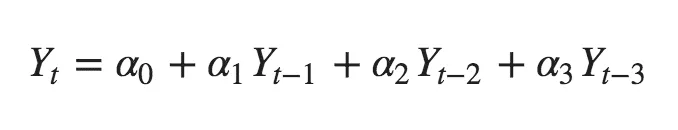

# numerical_data = df['Close']

plt.style.use('ggplot')
plot_pacf(df['Close'], lags=15)
plt.title(f"PACF of TSLA {TICKER} prices")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show()